# <center>Portfolio Optimization</center>

### Import libraries

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime, date
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

### Select data to perform analysis

In [3]:
#Select a start and end date for the data
start = datetime(2010,1,1)
end = date.today()

#List of securities
sec = ['AAPL', 'GOOG', 'TSLA', 'MSFT', 'JPM']
prices = pd.DataFrame()

#From the list of securities, get the Adjusted Close Price for every security, and save it into a DataFrame
for s in sec:
    prices[s] = web.DataReader(s, 'yahoo', start, end)['Adj Close']
    
#Rename the columns to the name of the securities
prices.columns = sec
#Drop every N/A value from the DataFrame
prices.dropna(inplace=True)

### Perform Monte Carlo Simulation by generating random weights

In [4]:
#Get the log returns from the data
returns = np.log(prices / prices.shift(1))

#Array of portfolio returns and standard deviation
port_ret = []
port_stdev = []

#Simulate different scenarios
for i in range(15000):    
    #Choose weights and normalize them
    weights = np.random.random(len(sec))
    weights /= np.sum(weights)

    #Calculate the annualized portfolio return
    port_ret.append(np.sum(returns.mean() * 252 * weights))

    #Calculate the annualized portfolio standard deviation
    port_stdev.append(np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights))))

port_ret = np.array(port_ret)
port_stdev = np.array(port_stdev)

### Display Monte Carlo Simulation

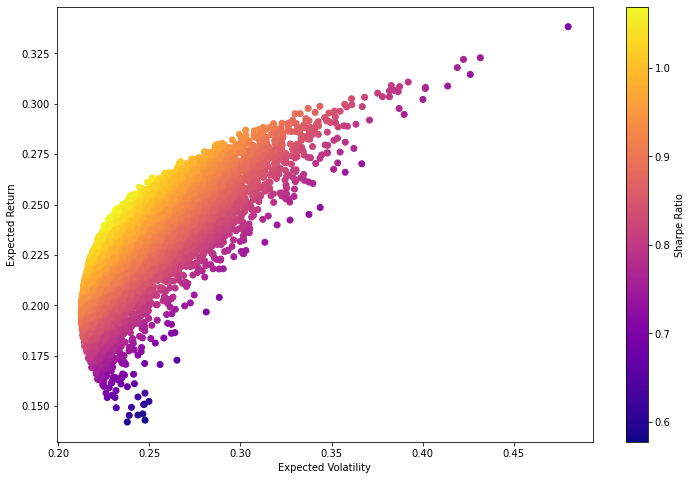

In [10]:
#Create plot
fig = plt.figure(figsize=(12,8))

plt.scatter(port_stdev, port_ret, c=port_ret / port_stdev, cmap='plasma')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio');

### Definition of functions

In [7]:
# Defining Statistics, Minimum Sharpe ratio, Minimum Volatility, and Results functions

def statistics(weights):
    '''
    Parameters
    ==========
    weights: array-like
        Weights for different securities in portfolio
    Returns
    =======
    port_ret: float
        Expected portfolio return
    port_stdev: float
        Expected portfolio standard deviation
    port_ret / port_stdev: float
        Portfolio Sharpe ratio
    '''
    #Transform the weights into a nd-array
    weights = np.array(weights)

    #Calculate the annualized portfolio return
    port_ret = np.sum(returns.mean() * 252 * weights)

    #Calculate the annualized portfolio standard deviation
    port_stdev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    
    return np.array([port_ret, port_stdev, port_ret / port_stdev])

def min_func_sharpe(weights):
    '''
    Parameters
    ==========
    weights: array-like
        Weights for different securities in portfolio
    Returns
    =======
    -statistics(weights)[2]: float
        Returns the negative Sharpe ratio of the portfolio
    '''
    return -statistics(weights)[2]

def min_volatility(weights):
    '''
    Parameters
    ==========
    weights: array-like
        Weights for different securities in portfolio
    Returns
    =======
    statistics(weights)[1]: float
        Returns the volatility of the portfolio
    '''
    return statistics(weights)[1]

def show_results():
    print("The weights for each security are:\n")
    for i in range(len(sec)):
        print(f"{sec[i]}: {(weights_opt[i]*100).round()}%")
    print("-------------")
    print(f"Total: {sum((weights_opt*100).round(2))}%\n")
    print(f"Portfolio Return: {(opt_ret*100).round(2)}%")
    print(f"Portfolio St.Dev.: {(opt_stdev*100).round(2)}%")
    print(f"Portfolio Sharpe Ratio: {(opt_ret/opt_stdev).round(2)}")

### Finding the Optimal Portfolio Allocation

In [8]:
#Set boundaries: weights between 0 and 1
bounds = tuple((0,1) for i in range(len(sec)))

#Set constraints: sum of all weights = 1
con = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1})

#Initial weights: uniform for every security
init_weights = np.full(len(sec), 1/len(sec))

#Find minimum negative Sharpe ratio using SciPy library
weights_opt = minimize(min_func_sharpe, init_weights, method='SLSQP',bounds=bounds,constraints=con)['x']
#Save the optimum return and standard deviation of the portfolio
opt_ret = statistics(weights_opt)[0]
opt_stdev = statistics(weights_opt)[1]

<Figure size 864x576 with 0 Axes>

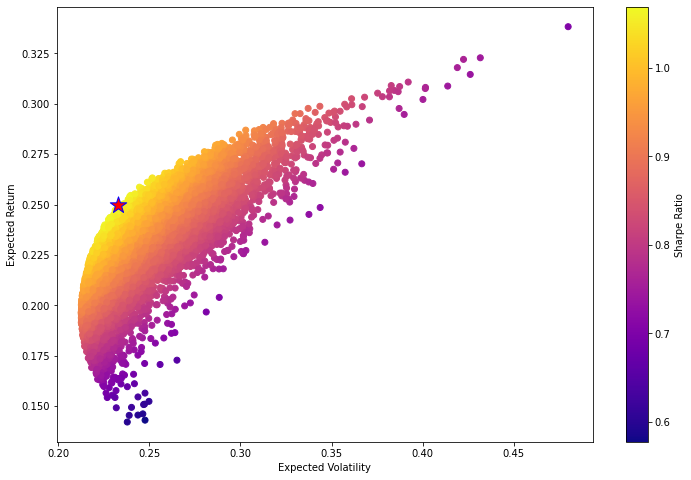

In [52]:
#Display the Optimal Portfolio
fig = plt.figure(figsize=(12,8))

fig = plt.figure(figsize=(12,8))

plt.scatter(port_stdev, port_ret, c=port_ret / port_stdev, cmap='plasma')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio');
plt.scatter(x=opt_stdev, y=opt_ret, c='red', ec='b', s=300, marker='*');

### Drawing the Efficient Frontier

In [22]:
#Set y values (expected return) of the frontier
return_frontier = np.linspace(port_ret.min(), port_ret.max(), 100)
#Create x values (expected volatility)
stdev_frontier = []

#Set x values (expected volatility)
for ret in return_frontier:
    #Set constraints to be: 
    #(1) Sum of weights = 1 and (2) the return selected by the weight equal to a value in the return_frontier array
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
           {'type': 'eq', 'fun': lambda w: statistics(w)[0] - ret})
    
    #Minimize volatility
    result = minimize(min_volatility,init_weights,method='SLSQP',bounds=bounds,constraints=cons)
    
    #Add them to the x values
    stdev_frontier.append(result['fun'])

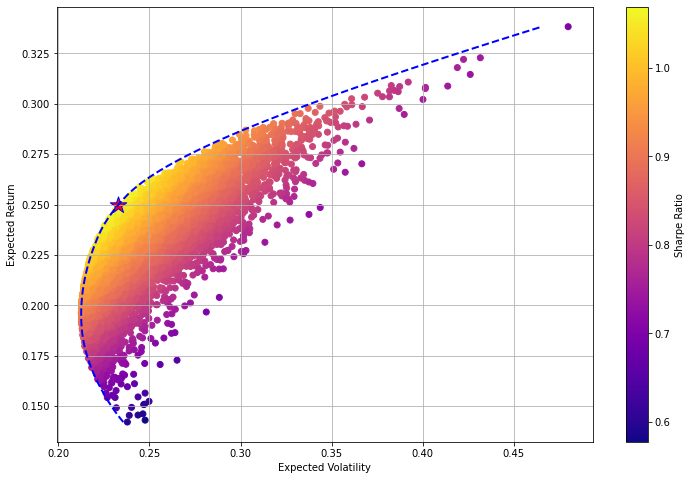

In [51]:
#Display the Optimal Portfolio and Efficient Frontier
fig = plt.figure(figsize=(12,8))

plt.scatter(port_stdev, port_ret, c=port_ret / port_stdev, cmap='plasma')
plt.colorbar(label='Sharpe Ratio');
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.scatter(x=opt_stdev, y=opt_ret, c='red', ec='b', s=300, marker='*')
plt.plot(stdev_frontier, return_frontier, '--b', lw=2)
plt.grid(True)

### Print Results

In [53]:
show_results()

The weights for each security are:

AAPL: 33.0%
GOOG: 4.0%
TSLA: 14.0%
MSFT: 49.0%
JPM: 0.0%
-------------
Total: 100.0%

Portfolio Return: 24.96%
Portfolio St.Dev.: 23.27%
Portfolio Sharpe Ratio: 1.07
